In [1]:
import time
import numpy as np
import pandas as pd
import math
import tqdm
import tqdm.notebook as tqdm_nb
import tqdm.auto as tqdm_a
from termcolor import colored
from functools import partial
from IPython.display import display

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (f1_score, precision_score, recall_score,
                             roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score
                            )
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.cluster import SpectralClustering
from sklearn.inspection import permutation_importance

import scipy.stats as sps
from catboost import CatBoostClassifier, CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

e:\Хакатоны\Цифровой прорыв\Цифровой Прорыв НН\samolet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_roc_curve(y, proba, sec_limits=None, label='', color='C0', fig=None, ax=None, return_figure=False):
    fpr, tpr, _ = roc_curve(y, proba)
    area = auc(fpr, tpr)
    
    # fig, ax = check_figax(fig, ax)
    fig.subplots_adjust(hspace=0.1)
    
    ax.plot(fpr, tpr, lw=2, color=color, label=f'{label} auc: {area:.5f}')
    ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    
    if sec_limits is None:
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
    else:
        ax.set_xlim(sec_limits[0])
        ax.set_ylim(sec_limits[1])
        
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_title('ROC curve', fontsize=15)
    ax.legend(loc='center right', fontsize=12)
    ax.grid()
    
    if return_figure: return fig


def plot_pr_curve(y, proba, sec_limits=None, label='', color='C0', fig=None, ax=None, return_figure=False):
    prec, rec, thres = precision_recall_curve(y, proba)
    area = auc(rec, prec)
    
    # fig, ax = check_figax(fig, ax)
    
    ax.plot(rec, prec, lw=2, color=color, label=f'{label} auc: {area:.5f}')
    
    if sec_limits is None:
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
    else:
        ax.set_xlim(sec_limits[0])
        ax.set_ylim(sec_limits[1])
        
    ax.set_xlabel('Recall', fontsize=14)
    ax.set_ylabel('Precision', fontsize=14)
    ax.set_title('PR curve', fontsize=15)
    ax.legend(loc='center right', fontsize=12)
    ax.grid()
    
    if return_figure: return fig

def plot_confusion(y, pred_label, fig=None, ax=None, return_figure=False, fmt='d'):
    cm = confusion_matrix(y, pred_label)
    
    if ax is None:  # Check if ax is None, and if so, create a new figure and ax.
        fig, ax = plt.subplots(figsize=(8, 8))
        
    ax.set_title('Confusion matrix')
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax, fmt=fmt)
    
    ax.set_xlabel('\nPredicted values')
    ax.set_ylabel('\nActual values')
    
    if return_figure: return fig

def find_best_threshold(y, proba, method='f1'):
    if method == 'f1':
        prec, rec, thres = precision_recall_curve(y, proba, pos_label=1)
        f1 = 2 * prec * rec / (prec + rec)
        ind = np.nanargmax(f1)
        best_thres = thres[ind]
        
    elif method == 'J':
        fpr, tpr, thres = roc_curve(y, proba, pos_label=1)
        J = tpr - fpr
        ind = np.nanargmax(J)
        best_thres = thres[ind]
        
    return best_thres


def predict_proba_4eval_sets(clf, eval_sets):
    target_proba_sets = list()
    lst_feats = clf.feature_names_
    for i in range(len(eval_sets)):
        X, y = eval_sets[i]
        target_proba_sets.append((y, clf.predict_proba(X[lst_feats])[:, 1]))
        
    return target_proba_sets

def get_metrics_clf(target_proba_sets, eval_names, thres_method='f1'):
    n = len(target_proba_sets)
    metrics_df = list()
    
    for i in range(n):
        y, proba = target_proba_sets[i]
        name = eval_names[i]
        best_thres = find_best_threshold(y, proba, thres_method)
        pred_label = np.where(proba > best_thres, 1, 0)
        
        acc = accuracy_score(y, pred_label)
        f1 = f1_score(y, pred_label)
        prec = precision_score(y, pred_label)
        rec = recall_score(y, pred_label)
        roc_auc = roc_auc_score(y, proba)
        metrics_df.append(pd.DataFrame({'sample': [name],
                                        'roc_auc': [roc_auc],
                                        'Best thres': [best_thres],
                                        'F1': [f1],
                                        'Prec': [prec],
                                        'Rec': [rec]}))
    metrics_df = pd.concat(metrics_df, ignore_index=True)
    
    return metrics_df


def evaluation_clf(target_proba_sets, eval_names, roc_limits=None, pr_limits=None, thres_method='f1'):
    n = len(target_proba_sets)
    colors = [f'C{i}' for i in range(n)]
    
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    ax1, ax2 = ax.ravel()
    
    metrics_df = get_metrics_clf(target_proba_sets, eval_names)
    
    for i in range(n):
        y, proba = target_proba_sets[i]
        name = eval_names[i]
        color = colors[i]
        
        best_thres = find_best_threshold(y, proba, thres_method)
        pred_label = np.where(proba > best_thres, 1, 0)
        
        plot_roc_curve(y, proba, label=name, color=color, sec_limits=roc_limits, fig=fig, ax=ax1, return_figure=False)
        fig = plot_pr_curve(y, proba, label=name, color=color, sec_limits=pr_limits, fig=fig, ax=ax2, return_figure=True)
        
    return fig, metrics_df



In [3]:
def build_cb_model(X_train, y_train, X_valid, y_valid, params=None, cat_features=[], 
                   verbose=50, seed=15, n_jobs=-1, fit_kwargs=None, task_type='binary'):
    
    params = {} if params is None else params.copy()
    params['verbose'] = params.get('verbose') or verbose
    params['random_state'] = params.get('random_state') or seed
    params['thread_count'] = params.get('thread_count') or n_jobs
    
    fit_kwargs =  {} if fit_kwargs is None else fit_kwargs.copy()
    
    if task_type == 'binary':
        model = CatBoostClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            cat_features = cat_features,
            **fit_kwargs
        )
        
    elif task_type == 'regression':
        model = CatBoostRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            cat_features = cat_features,
            **fit_kwargs
        )
    else:
        raise ValueError('task should be binary or regression')
        
    return model

def get_feature_importance(model):
    imp = pd.Series(model.feature_importances_,
                   index=model.feature_names_)\
                         .sort_values(ascending=False)\
                         .to_frame()\
                         .reset_index()\
                         .rename(columns={'index': 'feat_name', 0: 'feat_imp'})
    return imp

def plot_feature_importance(model, top_n=None, figsize=None):
    imp = get_feature_importance(model)
    
    fig, ax = plt.subplots(figsize=figsize or (12, 6))
    imp.set_index('feat_name')\
            .sort_values(by='feat_imp')\
            .tail(top_n or len(imp))\
            .plot(kind='barh', color='lightblue', ec='black', ax=ax, width=0.5)
    
    t = f"(Top: {top_n})" if top_n is not None else ""
    ax.set_title("Feature importance " + t)
    ax.grid(False, axis='y')
    
    return fig

def get_permutation_feature_importance(clf, X_test, y_test, scorer, n_repeats=10, seed=15, n_jobs=8, perm_kwargs=None):
    perm_kwargs = {}  if perm_kwargs is None else perm_kwargs.copy()
    perm_kwargs['n_repeats'] = perm_kwargs.get('n_repeats') or n_repeats
    perm_kwargs['random_state'] = perm_kwargs.get('random_state') or seed
    perm_kwargs['n_jobs'] = perm_kwargs.get('n_jobs') or n_jobs
    
    perm_result = permutation_importance(clf, X_test, y_test, scoring=scorer, **perm_kwargs)
    
    perm_imp_df = pd.DataFrame({'feat_name' : clf.feature_names_,
                                'feat_imp' : perm_result['importances_mean'],
                                'feat_imp_std' : perm_result['importances_std']})
    perm_imp_df = perm_imp_df.sort_values(by='feat_imp', ascending=False)\
                                .reset_index(drop=True)
    
    return perm_imp_df


def feat_selection_by_permutation(train_df, test_df, y_train, y_test, lst_feats=None, model_name=None, 
                                 model_params=None, scorer=None, perm_kwargs=None, add_noise_feats=True,
                                 seed=15, n_jobs=-1, fit_kwargs=None):
    model_params = {} if model_params is None else model_params.copy()
    fit_kwargs = {} if fit_kwargs is None else fit_kwargs.copy()
    perm_kwargs = {} if perm_kwargs is None else perm_kwargs.copy()
    
    lst_feats = train_df.columns.to_list() if lst_feats is None else lst_feats.copy()
    lst_cat_feats = [c for c in train_df.select_dtypes(include=['O', 'category']).columns if c in lst_feats]
    
    n_feats = len(lst_feats)
    train_df = train_df.copy()
    tets_df = test_df.copy()
    
    if add_noise_feats:
        train_df['NORMAL'] = sps.norm.rvs(loc=0, scale=1, size=len(train_df), random_state=seed)
        train_df['UNIFORM'] = sps.uniform.rvs(loc=0, scale=1, size=len(train_df), random_state=seed)
        
        test_df['NORMAL'] = sps.norm.rvs(loc=0, scale=1, size=len(test_df), random_state=seed)
        test_df['UNIFORM'] = sps.uniform.rvs(loc=0, scale=1, size=len(test_df), random_state=seed)
        lst_feats += ['NORMAL', 'UNIFORM']
        
    print(f">> Building model: {model_name}")
    start_t = time.time()
    
    if model_name == 'catboost':
        clf = build_cb_model(train_df[lst_feats], y_train, test_df[lst_feats], y_test,
                            cat_features=lst_cat_feats,
                            params=model_params,
                            verbose=0, seed=seed, n_jobs=-1, fit_kwargs=fit_kwargs)
    else:
        raise ValueError('incorrect model name')
        
    end_t = time.time()
    print(f">> Done ({end_t - start_t:.2f}s)")
    
    print(f"Start permutation", "with adding noise feats" if add_noise_feats else "", "...")
    
    perm_imp_df = get_permutation_feature_importance(clf, test_df[lst_feats], y_test, scorer, seed=seed, **perm_kwargs)
    
    if add_noise_feats:
        uniform_perm_value = perm_imp_df[perm_imp_df.feat_name == 'UNIFORM']['feat_imp'].values[0]
        normal_perm_value = perm_imp_df[perm_imp_df.feat_name == 'NORMAL']['feat_imp'].values[0]
        perm_filter = (perm_imp_df.feat_imp <= max(0, normal_perm_value, uniform_perm_value))
        perm_imp_df = perm_imp_df[~perm_filter].reset_index(drop=True)
        train_df.drop(['NORMAL', 'UNIFORM'], axis=1, inplace=True)
        test_df.drop(['NORMAL', 'UNIFORM'], axis=1, inplace=True)
    else:
        perm_filter = (perm_imp_df.feat_imp <= 0)
        perm_imp_df = perm_imp_df[~perm_filter].reset_index(drop=True)
        
    perm_imp_df = perm_imp_df.reset_index(drop=True)
    lst_sel_feats = perm_imp_df['feat_name'].to_list()
    
    end_t = time.time()
    print(f">> Done ({end_t - start_t:.2f}s)")
    print(f"Reduced number of feats: {n_feats} -> {len(lst_sel_feats)}")
    
    return perm_imp_df, lst_sel_feats

def custom_forward_selection(X_train, y_train, X_test, y_test, task_type='binary', eval_sets=None, eval_names=None,
                            lst_feats_for_select=None, cat_features=None, scorer=None, maximize_score=None, maximize_eval_name='Test',
                            metric_thres=1e-5, step=1, method='fast', reorder_init=False, model_name='catboost', model_params=None,
                             seed=15, n_jobs=-1, perm_kwargs=None, fit_kwargs=None):
    
    init_features = X_train.columns.to_list() if lst_feats_for_select is None else lst_feats_for_select
    cat_features = [] if cat_features is None else cat_features
    init_cat_features = [c for c in cat_features if c in set(init_features)]
    
    eval_sets = [(X_train, y_train), (X_test, y_test)] if eval_sets is None else eval_sets
    eval_names = ['Train', 'Test'] if eval_names is None else eval_names
    
    num_fs_steps = len(init_features)
    sign_coef = 1 if maximize_score else -1
    bad_fs_feats = []
    stop_selection_flag = False
    start_i = 0
    sel_features = []
    
    scores = {name : [] for name in eval_names}
    history = dict()
    history['metrics'] = list()
    history['scores'] = list()
    history['num_feats'] = list()
    history['sel_feats'] = list()
    history['iteration'] = list()
    
    progress = tqdm.tqdm(desc='fs_step')
    while not stop_selection_flag:
        excluded_feat = None
        
        n = len(init_features)
        n_iteration = (n + step - 1) // step
        
        for i in range(start_i, n_iteration):
            from_feat_idx = i * step
            to_feat_idx = (i + 1) * step
            feats = init_features[from_feat_idx: to_feat_idx]
            
            sel_features.extend(feats)
            print(sel_features)
            sel_cat_features = [c for c in init_cat_features if c in sel_features]
            
            print(f'--- Iteration: {i}. Number of feats: {to_feat_idx}/{n} ---')
            print(f'>> Building model: {model_name}')
            start_t = time.time()
            
            clf = build_cb_model(X_train[sel_features], y_train, 
                                     X_test[sel_features], y_test,
                                     cat_features=sel_cat_features, params=model_params,
                                     verbose=0, seed=seed, n_jobs=n_jobs, fit_kwargs=None)
            
            target_proba_sets = predict_proba_4eval_sets(clf, eval_sets)
            metrics_df = get_metrics_clf(target_proba_sets, eval_names=eval_names)
            display(metrics_df)
            
            for eval_samp, eval_name in zip(eval_sets, eval_names):
                score = scorer(clf, eval_samp[0][clf.feature_names_], eval_samp[1])
                scores[eval_name].append(score)
                
            end_t = time.time()
            print(f'>> Done ({end_t  - start_t:.2f}s)')
            
            if i > start_i:
                prev_valid = scores[maximize_eval_name][-2]
                curr_valid = scores[maximize_eval_name][-1]
                d_valid = sign_coef * (curr_valid - prev_valid)
                
                if (d_valid <= metric_thres):
                    print('>> Excluded:', feats)
                    print(*[f'>> score increase_{name}: {sign_coef*np.diff(scores[name][-2:])[0]:.3f}' for name in eval_names], sep='\n')
                    
                    new_init_features = [c for c in init_features if c not in set(feats)]
                    new_init_cat_features = [c for c in cat_features if c in set(new_init_features)]
                    
                    if reorder_init:
                        clf = build_cb_model(X_train[new_init_features], y_train,
                                                 X_test[new_init_features], y_test,
                                                 cat_features=new_init_cat_features, params=model_params,
                                                 verbose=0, seed=seed,  n_jobs=n_jobs, fit_kwargs=None)
                        start_t = time.time()
                        print(f'>> Start sorted features after excluding. Method: {method}')
                        if method == 'fast':
                            new_init_sorted_features = get_feature_importance(clf)['feat_name'].to_list()
                        elif method == 'permutation':
                            new_init_sorted_features = get_permutation_feature_importance(clf, X_test[new_init_features],
                                                                                          y_test, scorer)['feat_name'].to_list()
                            
                    init_features = new_init_sorted_features.copy() if reorder_init else new_init_features.copy()
                    init_cat_features = [c for c in cat_features if c in set(init_features)]
                    
                    excluded_feat = feats
                    bad_fs_feats.extend(excluded_feat)
                    
                    end_t = time.time()
                    print(f'>> Done ({end_t - start_t:.2f}s)')
                    break
                    
            history['metrics'].append(metrics_df)
            history['scores'].append(scores)
            history['num_feats'].append(len(sel_features))
            history['sel_feats'].append(sel_features.copy())
            history['iteration'].append(i)
                                        
        if excluded_feat is None:
            stop_selection_flag = True
        else:
            if reorder_init:
                start_i = 0
                sel_features = []
                scores = {name: [] for name in eval_names}
                history = dict()
                history['metrics'] = list()
                history['scores'] = list()
                history['num_feats'] = list()
                history['sel_feats'] = list()
                history['iteration'] = list()                     
            else:
                start_i = from_feat_idx
                sel_features = init_features[:start_i]                       

        progress.update()
        print('*'*50)
    print(f'>> Finish. Number of features in final subset: {len(sel_features)}')

    return(history)

In [4]:
your_path_to_csv = 'E:/Хакатоны/Цифровой прорыв/Цифровой Прорыв НН/data/train_dataset.csv'  #заменить путь на свой
df = pd.read_csv(your_path_to_csv)

In [5]:
print(df.shape)
df.report_date = pd.to_datetime(df.report_date)

(14456, 2666)


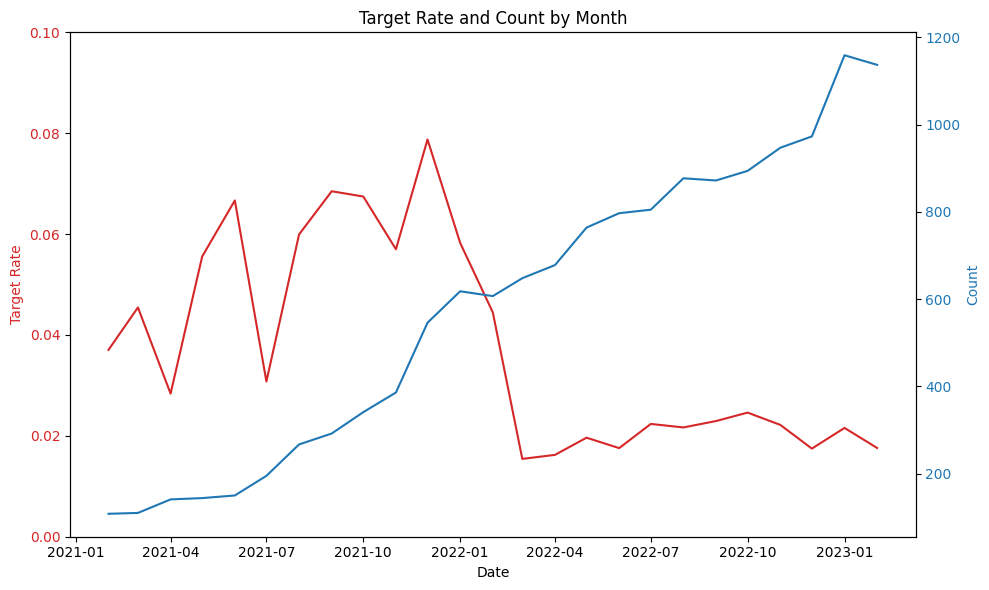

In [6]:
# График Target Rate
df['year_month'] = df['report_date'].dt.to_period('M')

# Group by month and year
grouped = df.groupby('year_month').agg(
    target_rate=('target', 'mean'),
    count=('target', 'size')
)

grouped.index = grouped.index.astype('datetime64[ns]')
fig, ax1 = plt.subplots(figsize=(10, 6))


# Plot target rate on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylim([0, 0.1])
ax1.set_ylabel('Target Rate', color=color)
ax1.plot(grouped.index, grouped['target_rate'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create another y-axis for the count
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Count', color=color)
ax2.plot(grouped.index, grouped['count'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Target Rate and Count by Month')
plt.tight_layout()
plt.show()

In [7]:
# Нормализация Target Rate для компенсирования падения
tmp = df[(df.report_date > '2022-02-01')]

tmp1 = df[(df.report_date == '2021-02-01')]
percent_to_remove = 0.4
mask = tmp1['target'] == 1
indices_to_remove = tmp1[mask].sample(frac=percent_to_remove).index
tmp1 = tmp1.drop(indices_to_remove)

tmp2 = df[(df.report_date == '2021-03-01')]
percent_to_remove = 0.55
mask = tmp2['target'] == 1
indices_to_remove = tmp2[mask].sample(frac=percent_to_remove).index
tmp2 = tmp2.drop(indices_to_remove)

tmp3 = df[(df.report_date == '2021-04-01') | (df.report_date == '2021-07-01')]
percent_to_remove = 0.2
mask = tmp3['target'] == 1
indices_to_remove = tmp3[mask].sample(frac=percent_to_remove).index
tmp3 = tmp3.drop(indices_to_remove)

tmp4 = df[(df.report_date == '2021-05-01') | (df.report_date == '2021-06-01')]
percent_to_remove = 0.6
mask = tmp4['target'] == 1
indices_to_remove = tmp4[mask].sample(frac=percent_to_remove).index
tmp4 = tmp4.drop(indices_to_remove)

tmp5 = df[(df.report_date == '2021-08-01') | (df.report_date == '2021-09-01') \
          | (df.report_date == '2021-10-01') | (df.report_date == '2021-11-01')]
percent_to_remove = 0.7
mask = tmp5['target'] == 1
indices_to_remove = tmp5[mask].sample(frac=percent_to_remove).index
tmp5 = tmp5.drop(indices_to_remove)

tmp6 = df[(df.report_date == '2021-12-01')]
percent_to_remove = 0.7
mask = tmp6['target'] == 1
indices_to_remove = tmp6[mask].sample(frac=percent_to_remove).index
tmp6 = tmp6.drop(indices_to_remove)

In [8]:
new_df = pd.concat([tmp, tmp1, tmp2, tmp3, tmp4, tmp5, tmp6], axis = 0)

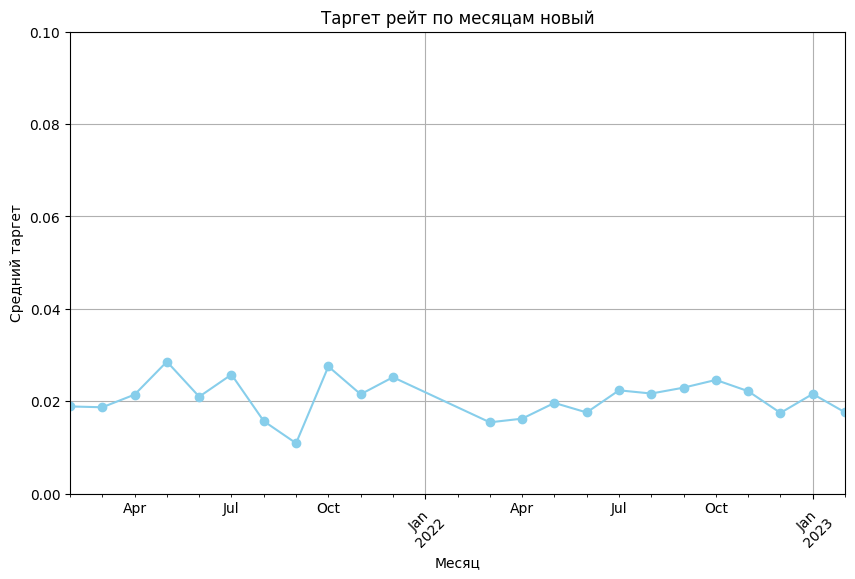

Размер выборки с изначальным таргет рейтом: 14456
Размер выборки с новым таргет рейтом: 13126


In [9]:
# График нового Target Rate
monthly_target = new_df.groupby(new_df['report_date'].dt.to_period('M'))['target'].mean()

plt.figure(figsize=(10, 6))
monthly_target.plot(kind='line', marker='o', color='skyblue')
plt.ylim([0, 0.1])
plt.xlabel('Месяц')
plt.ylabel('Средний таргет')
plt.title('Таргет рейт по месяцам новый')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print(f"Размер выборки с изначальным таргет рейтом: {df.shape[0]}")
print(f"Размер выборки с новым таргет рейтом: {new_df.shape[0]}")

In [10]:
df = new_df.copy()

ignore_features = ['report_date', 'client_id', 'target', 'year_month']

nan_percentage = df.isna().mean()
cols_to_drop = nan_percentage[nan_percentage > 0.95].index
df_cleaned = df.drop(columns=cols_to_drop)
print(df_cleaned.shape)

(13126, 980)


In [11]:
# Удаление фичей, которые коррелируют друг с другом больше, чем на 0.9
def get_correlated_feats(corr_matrix, feat_stats, greater_is_better=True, corr_threshold=0.9):
    cols = corr_matrix.columns.to_list()
    dropped = {col:0 for col in cols}
    for col in tqdm.tqdm(cols, desc='Get correlated features'):
        if dropped[col] == 0:
            columns_to_check = corr_matrix.index.values[np.abs(corr_matrix[col]) >= corr_threshold]
            if len(columns_to_check) > 1:
                print(f'{col} -> {columns_to_check}')
                if feat_stats is None:
                    bad_cols = columns_to_check[1:]
                else:
                    sel_stats = feat_stats.loc[columns_to_check]
                    if greater_is_better:
                        bad_cond = np.abs(sel_stats) < np.abs(sel_stats).max()
                    else:
                        bad_cond = np.abs(sel_stats) > np.abs(sel_stats).min()
                        
                    bad_cols = sel_stats[bad_cond].index.to_list()
                    norm_cols = sel_stats[~bad_cond].index.to_list()
                    if len(norm_cols) > 1:
                        for norm_col in norm_cols[1:]:
                            dropped[norm_col] += 1
                            
                for bad_col in bad_cols:
                    dropped[bad_col] += 1
                
    high_corr_cols = [c for c in dropped.keys() if dropped[c] > 0]
    return high_corr_cols

In [12]:
corr_mx = df_cleaned.drop(columns=ignore_features).corr()

corr_feats = get_correlated_feats(corr_mx, feat_stats=nan_percentage, greater_is_better=False, corr_threshold=0.9)
len(corr_feats)

Get correlated features:  44%|████▍     | 410/932 [00:00<00:00, 2211.43it/s]

col280 -> ['col280' 'col320']
col284 -> ['col284' 'col324']
col288 -> ['col288' 'col292' 'col328']
col296 -> ['col292' 'col296']
col300 -> ['col300' 'col340']
col304 -> ['col304' 'col344']
col308 -> ['col308' 'col312' 'col348']
col316 -> ['col312' 'col316']
col320 -> ['col280' 'col320']
col324 -> ['col284' 'col324']
col328 -> ['col288' 'col328' 'col332']
col340 -> ['col300' 'col340']
col344 -> ['col304' 'col344']
col348 -> ['col308' 'col348' 'col352']
col388 -> ['col388' 'col392']
col396 -> ['col392' 'col396']
col408 -> ['col408' 'col412']
col420 -> ['col420' 'col428']
col448 -> ['col448' 'col452']
col474 -> ['col474' 'col475' 'col482' 'col483' 'col484' 'col486' 'col490' 'col491']
col476 -> ['col475' 'col476' 'col484']
col478 -> ['col478' 'col482' 'col483' 'col486']
col487 -> ['col475' 'col482' 'col483' 'col484' 'col486' 'col487' 'col488' 'col490'
 'col491']
col492 -> ['col482' 'col483' 'col484' 'col486' 'col488' 'col490' 'col491' 'col492']
col494 -> ['col494' 'col495' 'col496' 'col502

Get correlated features: 100%|██████████| 932/932 [00:00<00:00, 2444.23it/s]

col2202 -> ['col2202' 'col2205' 'col2208' 'col2211' 'col2217']
col2203 -> ['col2203' 'col2218']
col2204 -> ['col2204' 'col2219']
col2207 -> ['col2207' 'col2210']
col2210 -> ['col2207' 'col2210']
col2211 -> ['col2202' 'col2205' 'col2208' 'col2211' 'col2217']
col2220 -> ['col2220' 'col2340']
col2226 -> ['col2226' 'col2228' 'col2229' 'col2231' 'col2232' 'col2235' 'col2238'
 'col2244']
col2227 -> ['col2227' 'col2230']
col2230 -> ['col2227' 'col2230' 'col2233' 'col2236' 'col2239' 'col2245']
col2234 -> ['col2228' 'col2229' 'col2231' 'col2232' 'col2234' 'col2237' 'col2240'
 'col2246']
col2244 -> ['col2226' 'col2229' 'col2232' 'col2235' 'col2238' 'col2240' 'col2244'
 'col2246']
col2245 -> ['col2230' 'col2233' 'col2236' 'col2239' 'col2240' 'col2245' 'col2246']
col2275 -> ['col1983' 'col1986' 'col1989' 'col1992' 'col1998' 'col2274' 'col2275'
 'col2276' 'col2277' 'col2278' 'col2279' 'col2280' 'col2281' 'col2282'
 'col2283' 'col2284' 'col2285' 'col2287' 'col2288' 'col2289' 'col2290'
 'col2291' 'co

501

In [13]:
df_no_corr = df_cleaned.drop(columns=corr_feats)
df_no_corr.shape

(13126, 479)

In [14]:
df_new = df_no_corr.copy()
df_new['report_date'] = df_new['report_date'].astype('datetime64[ns]')
df_new = df_new.sort_values(by='report_date')

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

def compare_columns(df):
    columns = df.columns
    results = pd.DataFrame(index=columns, columns=columns)

    for col1 in tqdm.tqdm(columns):
        for col2 in columns:
            set1 = set(df[col1].dropna().unique())
            set2 = set(df[col2].dropna().unique())
            results.loc[col1, col2] = jaccard_similarity(set1, set2)

    return results

cat_columns = df_new.select_dtypes('object')
compare_df = compare_columns(cat_columns)

def get_unique_columns(similarity_matrix, threshold=0.26):

    columns_to_remove = set()
    for i in range(similarity_matrix.shape[0]):
        for j in range(i+1, similarity_matrix.shape[1]):
            if isinstance(similarity_matrix, np.ndarray):
                value = similarity_matrix[i, j]
            else:  # Если это DataFrame
                value = similarity_matrix.iloc[i, j]
            if value >= threshold:
                columns_to_remove.add(j)

    # Получить названия удаленных колонок (если это DataFrame)
    if isinstance(similarity_matrix, pd.DataFrame):
        removed_column_names = [similarity_matrix.columns[i] for i in columns_to_remove]

    # Удалить дублирующиеся колонки из матрицы
    if isinstance(similarity_matrix, np.ndarray):
        updated_matrix = np.delete(similarity_matrix, list(columns_to_remove), axis=1)
        updated_matrix = np.delete(updated_matrix, list(columns_to_remove), axis=0)
    else:  # Если это DataFrame
        updated_matrix = similarity_matrix.drop(similarity_matrix.columns[list(columns_to_remove)], axis=1)
        updated_matrix = updated_matrix.drop(similarity_matrix.index[list(columns_to_remove)], axis=0)

    return updated_matrix

mat = get_unique_columns(compare_df)

100%|██████████| 44/44 [00:03<00:00, 11.13it/s]


In [15]:
len(mat.columns.values)

18

In [16]:
# Разделение на train-valid-OutOfTime
model_df = df_new.copy()
train_mask = model_df.report_date <= '2022-09-01'
valid_mask = (model_df.report_date > '2022-09-01') & (model_df.report_date <= '2023-01-01')
oot_mask = model_df.report_date > '2023-01-01'

model_df.loc[train_mask, 'sample'] = 'Train'
model_df.loc[valid_mask, 'sample'] = 'Valid(OOT)'
model_df.loc[oot_mask, 'sample'] = 'Test(OOT)'

In [17]:
def get_samp_descr_for_binary_task(df, sample_col, date_col, target_col, feature_cols):
    sample_names = df[sample_col].unique()
    for name in sample_names:
        samp = df[df[sample_col] == name]
        print(colored(f'{name:}', None, attrs=['bold']))
        print('Period from:', samp[date_col].dt.date.min(), 'to', samp[date_col].dt.date.max())
        print('Target rate:', round(samp[target_col].mean(), 6))
        print('Count of target 1:', samp[target_col].sum())
        print('Shape of sample:', samp[feature_cols].shape)
        print('--------------------------------------------------------------------')

In [18]:
sample = 'sample'
target = 'target'
report_date = 'report_date'

In [19]:
nums = df_new.select_dtypes(include=['int64', 'float64']).columns.tolist()
cats = list(set(mat.columns.to_list() + df_new.select_dtypes(include=['O']).columns.tolist()))

ignore_features = ['report_date', 'client_id', 'target', 'year_month', 'sample', 'col1454']
cat_features = [c for c in cats if c not in ignore_features]
cols = [c for c in nums if c not in ignore_features] + cat_features

In [20]:
get_samp_descr_for_binary_task(model_df, sample_col=sample, date_col=report_date, target_col=target, feature_cols=cols)

Train
Period from: 2021-02-01 to 2022-09-01
Target rate: 0.020334
Count of target 1: 163
Shape of sample: (8016, 474)
--------------------------------------------------------------------
Valid(OOT)
Period from: 2022-10-01 to 2023-01-01
Target rate: 0.021394
Count of target 1: 85
Shape of sample: (3973, 474)
--------------------------------------------------------------------
Test(OOT)
Period from: 2023-02-01 to 2023-02-01
Target rate: 0.01759
Count of target 1: 20
Shape of sample: (1137, 474)
--------------------------------------------------------------------


In [21]:
model_df[cat_features] = model_df[cat_features].fillna('unknown')

for col in cat_features:
    model_df[col] = model_df[col].astype(str)

catboost_params = {
    'iterations': 200,
    'learning_rate': 0.01,
    'depth': 6,
    'eval_metric': 'AUC',
    # 'class_weights': [1, (2296 / 45)]
}

In [22]:
clf = build_cb_model(model_df[train_mask][cols], model_df[train_mask].target,
                     model_df[valid_mask][cols], model_df[valid_mask].target, 
                     cat_features=cat_features, params=catboost_params)

0:	test: 0.5966866	best: 0.5966866 (0)	total: 371ms	remaining: 1m 13s
50:	test: 0.7175744	best: 0.7245945 (42)	total: 8.53s	remaining: 24.9s
100:	test: 0.7325617	best: 0.7325617 (100)	total: 15.5s	remaining: 15.2s
150:	test: 0.7585920	best: 0.7585920 (150)	total: 22.6s	remaining: 7.32s
199:	test: 0.7909692	best: 0.7909692 (199)	total: 29.3s	remaining: 0us

bestTest = 0.7909691963
bestIteration = 199



,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.845164,0.070955,0.398374,0.590361,0.300613
1,Valid(OOT),0.790969,0.065001,0.188525,0.144654,0.270588


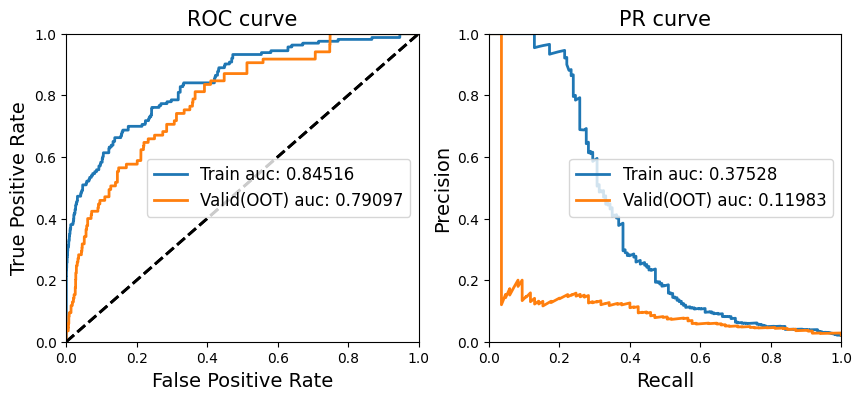

In [23]:
target_proba_sets = predict_proba_4eval_sets(clf, [(model_df[train_mask][cols], model_df[train_mask].target),
                     (model_df[valid_mask][cols], model_df[valid_mask].target)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid(OOT)'], thres_method='J')

display(metrics_df)

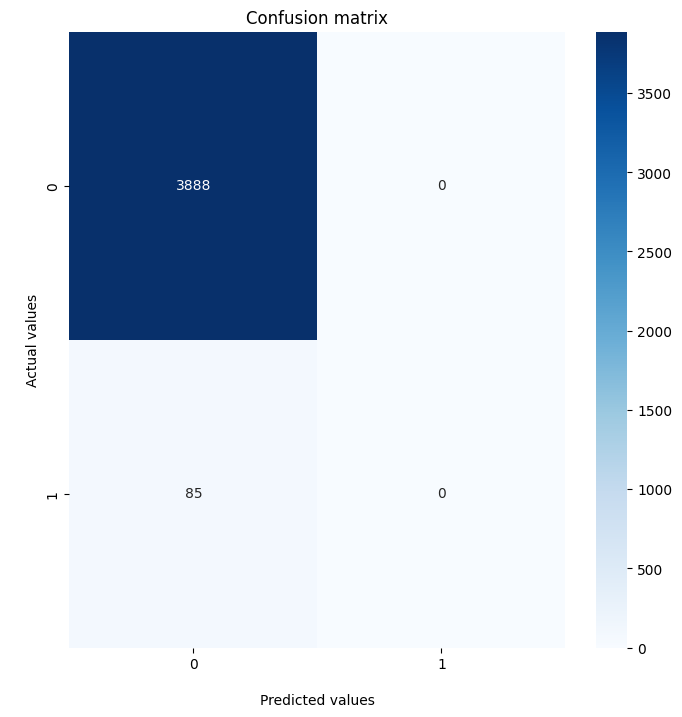

In [24]:
y_pred = clf.predict(model_df[valid_mask][cols])
plot_confusion(model_df[valid_mask].target, y_pred)

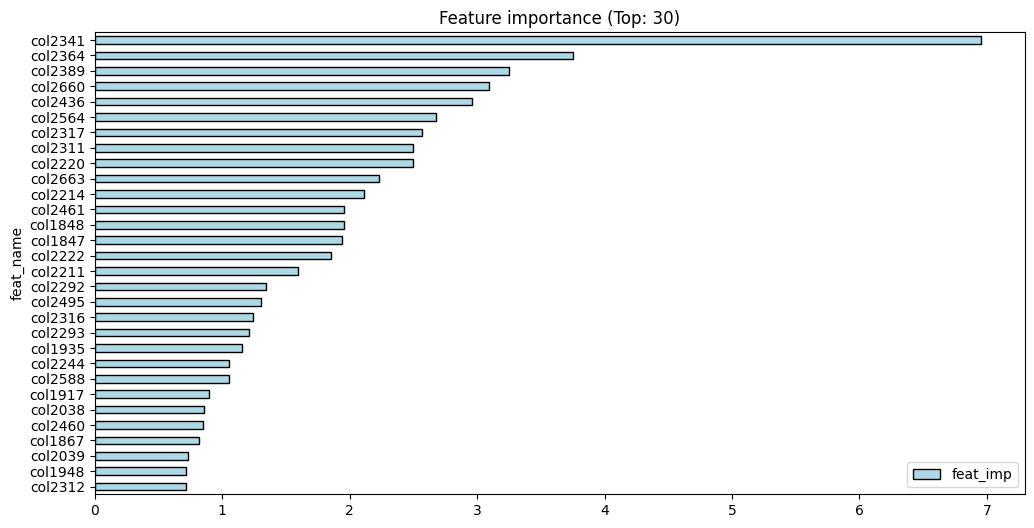

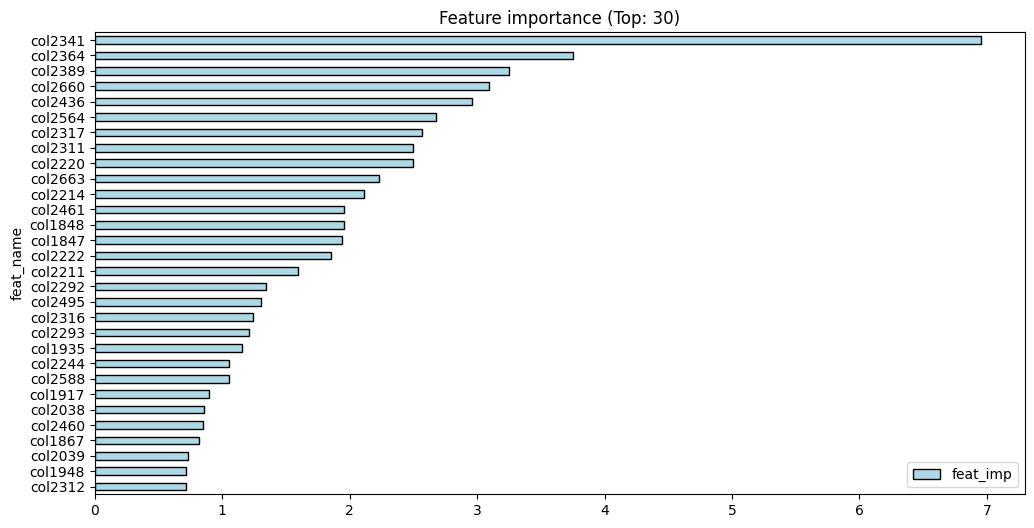

In [25]:
imp = get_feature_importance(clf)

zero_imp = imp[imp.feat_imp == 0.0].feat_name.values
plot_feature_importance(clf, top_n=30)

In [26]:
model_df = model_df.drop(columns=zero_imp)

cols = model_df.drop(columns=ignore_features).columns.to_list()
cat_features = model_df[cols].select_dtypes(include=['object']).columns.tolist()

clf = build_cb_model(model_df[train_mask][cols], model_df[train_mask].target,
                     model_df[valid_mask][cols], model_df[valid_mask].target, 
                     cat_features=cat_features, params=catboost_params)

0:	test: 0.4851171	best: 0.4851171 (0)	total: 132ms	remaining: 26.2s
50:	test: 0.7277248	best: 0.7370824 (33)	total: 5.69s	remaining: 16.6s
100:	test: 0.7436925	best: 0.7457683 (87)	total: 10.4s	remaining: 10.2s
150:	test: 0.7736656	best: 0.7743343 (148)	total: 15.3s	remaining: 4.96s
199:	test: 0.7954127	best: 0.7967320 (196)	total: 20.2s	remaining: 0us

bestTest = 0.7967320261
bestIteration = 196

Shrink model to first 197 iterations.


In [27]:
perm_imp_df, lst_sel_feats = feat_selection_by_permutation(
    model_df[cols][train_mask], model_df[cols][valid_mask], 
    model_df[train_mask].target, model_df[valid_mask].target, lst_feats=cols, 
    model_name='catboost', model_params=catboost_params, scorer='roc_auc')

>> Building model: catboost
>> Done (21.54s)
Start permutation with adding noise feats ...
>> Done (154.72s)
Reduced number of feats: 288 -> 53


In [28]:
lst_sel_feats

['col2220',
 'col2389',
 'col2663',
 'col2341',
 'col2436',
 'col2038',
 'col2292',
 'col2293',
 'col2222',
 'col2318',
 'col2660',
 'col2312',
 'col2470',
 'col2308',
 'col2216',
 'col268',
 'col2460',
 'col2311',
 'col2364',
 'col340',
 'col644',
 'col628',
 'col1970',
 'col2316',
 'col2214',
 'col2317',
 'col2182',
 'col380',
 'col2461',
 'col2221',
 'col620',
 'col2486',
 'col816',
 'col2167',
 'col1973',
 'col256',
 'col2215',
 'col676',
 'col2244',
 'col1461',
 'col276',
 'col2520',
 'col496',
 'col2170',
 'col624',
 'col364',
 'col432',
 'col2183',
 'col2190',
 'col2211',
 'col764',
 'col684',
 'col2212']

In [29]:
cols = lst_sel_feats.copy()
cat_features = model_df[cols].select_dtypes(include=['object']).columns.tolist()

In [30]:
clf = build_cb_model(model_df[train_mask][cols], model_df[train_mask].target,
                     model_df[valid_mask][cols], model_df[valid_mask].target, 
                     cat_features=cat_features, params=catboost_params)

0:	test: 0.6952887	best: 0.6952887 (0)	total: 38.3ms	remaining: 7.62s
50:	test: 0.8058521	best: 0.8087237 (44)	total: 628ms	remaining: 1.83s
100:	test: 0.8096254	best: 0.8103123 (97)	total: 1.24s	remaining: 1.21s
150:	test: 0.8274994	best: 0.8274994 (150)	total: 1.88s	remaining: 612ms
199:	test: 0.8420298	best: 0.8420298 (199)	total: 3.18s	remaining: 0us

bestTest = 0.8420297749
bestIteration = 199



,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.86776,0.092427,0.386266,0.642857,0.276074
1,Valid(OOT),0.84203,0.066019,0.221374,0.163842,0.341176


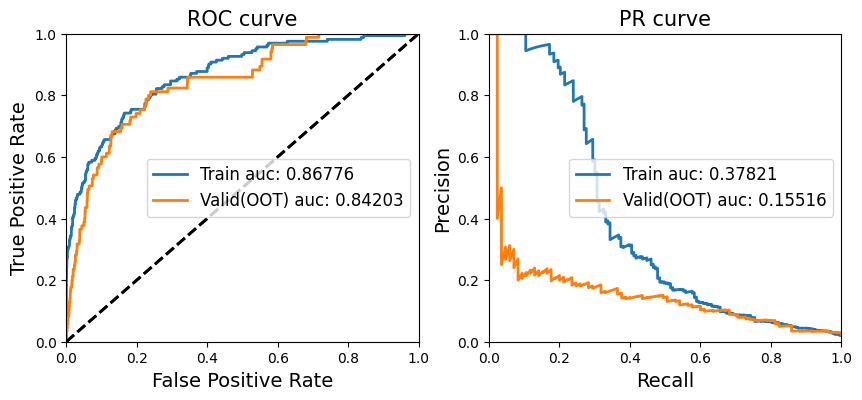

In [31]:
target_proba_sets = predict_proba_4eval_sets(clf, [(model_df[train_mask][cols], model_df[train_mask].target),
                     (model_df[valid_mask][cols], model_df[valid_mask].target)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid(OOT)'], thres_method='f1')

display(metrics_df)

In [32]:
def custom_auc_scorer(model, X, y_true):
    y_pred = model.predict_proba(X)[:, 1] # Assuming binary classification
    return roc_auc_score(y_true, y_pred)

In [33]:
history = custom_forward_selection(model_df[train_mask][cols], model_df[train_mask].target,
                     model_df[valid_mask][cols], model_df[valid_mask].target, eval_sets=[(model_df[train_mask][cols], model_df[train_mask].target), (model_df[valid_mask][cols], model_df[valid_mask].target)], eval_names=['Train', 'Valid(OOT)'],
                     lst_feats_for_select=cols, cat_features=cat_features, scorer=custom_auc_scorer, method='permutation', model_params=catboost_params, maximize_eval_name='Valid(OOT)')

fs_step: 0it [00:00, ?it/s]

['col2220']
--- Iteration: 0. Number of feats: 1/53 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.740577,0.079164,0.134529,0.106007,0.184049
1,Valid(OOT),0.736792,0.079346,0.107143,0.076923,0.176471


>> Done (1.63s)
['col2220', 'col2389']
--- Iteration: 1. Number of feats: 2/53 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.762528,0.465642,0.155932,0.174242,0.141104
1,Valid(OOT),0.773316,0.463388,0.153846,0.093995,0.423529


fs_step: 1it [00:04,  4.47s/it]

>> Done (2.84s)
>> Excluded: ['col2389']
>> score increase_Train: -0.022
>> score increase_Valid(OOT): -0.037
>> Done (2.84s)
**************************************************
['col2220', 'col2663']
--- Iteration: 1. Number of feats: 2/52 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.768307,0.163930,0.168498,0.209091,0.141104
1,Valid(OOT),0.835780,0.143607,0.188889,0.112088,0.600000


>> Done (1.89s)
['col2220', 'col2663', 'col2341']
--- Iteration: 2. Number of feats: 3/52 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.784629,0.452603,0.169492,0.140000,0.214724
1,Valid(OOT),0.850700,0.454366,0.235772,0.180124,0.341176


fs_step: 2it [00:08,  3.98s/it]

>> Done (1.74s)
>> Excluded: ['col2341']
>> score increase_Train: -0.016
>> score increase_Valid(OOT): -0.015
>> Done (1.74s)
**************************************************
['col2220', 'col2663', 'col2436']
--- Iteration: 2. Number of feats: 3/51 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.771396,0.477604,0.156028,0.184874,0.134969
1,Valid(OOT),0.855666,0.477722,0.174419,0.172414,0.176471


>> Done (3.20s)
['col2220', 'col2663', 'col2436', 'col2038']
--- Iteration: 3. Number of feats: 4/51 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.773357,0.387640,0.224900,0.167164,0.343558
1,Valid(OOT),0.834636,0.395715,0.172727,0.140741,0.223529


>> Done (1.68s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2292']
--- Iteration: 4. Number of feats: 5/51 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.852958,0.103451,0.349442,0.443396,0.288344
1,Valid(OOT),0.846903,0.096974,0.222222,0.220930,0.223529


fs_step: 3it [00:15,  5.68s/it]

>> Done (2.82s)
>> Excluded: ['col2292']
>> score increase_Train: -0.080
>> score increase_Valid(OOT): -0.012
>> Done (2.82s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293']
--- Iteration: 4. Number of feats: 5/50 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.849899,0.127553,0.348936,0.569444,0.251534
1,Valid(OOT),0.844137,0.094088,0.229665,0.193548,0.282353


>> Done (2.14s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222']
--- Iteration: 5. Number of feats: 6/50 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.854795,0.117055,0.372470,0.547619,0.282209
1,Valid(OOT),0.843581,0.091518,0.234043,0.213592,0.258824


>> Done (2.01s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2318']
--- Iteration: 6. Number of feats: 7/50 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.872739,0.12097,0.387387,0.728814,0.263804
1,Valid(OOT),0.852029,0.07916,0.258303,0.188172,0.411765


fs_step: 4it [00:23,  6.41s/it]

>> Done (3.38s)
>> Excluded: ['col2318']
>> score increase_Train: -0.018
>> score increase_Valid(OOT): -0.008
>> Done (3.38s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660']
--- Iteration: 6. Number of feats: 7/49 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.865013,0.112433,0.362903,0.529412,0.276074
1,Valid(OOT),0.842576,0.081292,0.198582,0.142132,0.329412


>> Done (1.64s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312']
--- Iteration: 7. Number of feats: 8/49 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.873427,0.114353,0.398374,0.590361,0.300613
1,Valid(OOT),0.839983,0.132383,0.195122,0.315789,0.141176


>> Done (3.17s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2470']
--- Iteration: 8. Number of feats: 9/49 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.880036,0.084034,0.413580,0.416149,0.411043
1,Valid(OOT),0.842478,0.087607,0.237885,0.190141,0.317647


fs_step: 5it [00:30,  6.54s/it]

>> Done (1.96s)
>> Excluded: ['col2470']
>> score increase_Train: -0.007
>> score increase_Valid(OOT): -0.002
>> Done (1.96s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308']
--- Iteration: 8. Number of feats: 9/48 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.880943,0.096642,0.408451,0.479339,0.355828
1,Valid(OOT),0.830838,0.116259,0.208955,0.285714,0.164706


>> Done (3.06s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col2216']
--- Iteration: 9. Number of feats: 10/48 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.887400,0.089646,0.398577,0.474576,0.343558
1,Valid(OOT),0.841947,0.128884,0.213115,0.351351,0.152941


fs_step: 6it [00:35,  6.06s/it]

>> Done (2.08s)
>> Excluded: ['col2216']
>> score increase_Train: -0.006
>> score increase_Valid(OOT): -0.011
>> Done (2.08s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268']
--- Iteration: 9. Number of feats: 10/47 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.878260,0.077714,0.405797,0.384615,0.429448
1,Valid(OOT),0.848293,0.122778,0.208000,0.325000,0.152941


>> Done (2.47s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460']
--- Iteration: 10. Number of feats: 11/47 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.876559,0.093321,0.382812,0.526882,0.300613
1,Valid(OOT),0.846901,0.068298,0.233438,0.159483,0.435294


>> Done (3.87s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311']
--- Iteration: 11. Number of feats: 12/47 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.882987,0.075288,0.416185,0.393443,0.441718
1,Valid(OOT),0.845125,0.113554,0.237037,0.320000,0.188235


>> Done (1.58s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364']
--- Iteration: 12. Number of feats: 13/47 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.873115,0.126093,0.379630,0.773585,0.251534
1,Valid(OOT),0.835706,0.093387,0.211055,0.184211,0.247059


>> Done (3.68s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col340']
--- Iteration: 13. Number of feats: 14/47 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.875430,0.098666,0.395161,0.576471,0.300613
1,Valid(OOT),0.847056,0.071271,0.221453,0.156863,0.376471


fs_step: 7it [00:49,  8.63s/it]

>> Done (2.32s)
>> Excluded: ['col340']
>> score increase_Train: -0.002
>> score increase_Valid(OOT): -0.011
>> Done (2.32s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644']
--- Iteration: 13. Number of feats: 14/46 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.869718,0.113221,0.423729,0.684932,0.306748
1,Valid(OOT),0.835660,0.092483,0.231884,0.196721,0.282353


>> Done (2.26s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col628']
--- Iteration: 14. Number of feats: 15/46 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.864015,0.123538,0.407240,0.775862,0.276074
1,Valid(OOT),0.848203,0.112891,0.231293,0.274194,0.200000


fs_step: 8it [00:55,  7.79s/it]

>> Done (3.72s)
>> Excluded: ['col628']
>> score increase_Train: 0.006
>> score increase_Valid(OOT): -0.013
>> Done (3.72s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970']
--- Iteration: 14. Number of feats: 15/45 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.864257,0.123089,0.411215,0.862745,0.269939
1,Valid(OOT),0.846044,0.096149,0.263158,0.238095,0.294118


>> Done (1.92s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316']
--- Iteration: 15. Number of feats: 16/45 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.861540,0.118996,0.429825,0.753846,0.300613
1,Valid(OOT),0.842131,0.083820,0.221277,0.173333,0.305882


>> Done (3.56s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2214']
--- Iteration: 16. Number of feats: 17/45 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.870440,0.099635,0.398374,0.590361,0.300613
1,Valid(OOT),0.850946,0.066909,0.233236,0.155039,0.470588


fs_step: 9it [01:02,  7.60s/it]

>> Done (1.72s)
>> Excluded: ['col2214']
>> score increase_Train: -0.009
>> score increase_Valid(OOT): -0.009
>> Done (1.72s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317']
--- Iteration: 16. Number of feats: 17/44 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.870219,0.117689,0.419214,0.727273,0.294479
1,Valid(OOT),0.842195,0.088645,0.232759,0.183673,0.317647


>> Done (3.25s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col2182']
--- Iteration: 17. Number of feats: 18/44 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.865030,0.122395,0.434389,0.827586,0.294479
1,Valid(OOT),0.852165,0.105888,0.239521,0.243902,0.235294


fs_step: 10it [01:10,  7.90s/it]

>> Done (5.31s)
>> Excluded: ['col2182']
>> score increase_Train: 0.005
>> score increase_Valid(OOT): -0.010
>> Done (5.31s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380']
--- Iteration: 17. Number of feats: 18/43 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.867433,0.118226,0.432432,0.813559,0.294479
1,Valid(OOT),0.846373,0.074736,0.222222,0.155660,0.388235


>> Done (4.90s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461']
--- Iteration: 18. Number of feats: 19/43 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.863498,0.106624,0.426087,0.731343,0.300613
1,Valid(OOT),0.838343,0.104201,0.222222,0.250000,0.200000


>> Done (5.13s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col2221']
--- Iteration: 19. Number of feats: 20/43 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.871661,0.130008,0.411215,0.862745,0.269939
1,Valid(OOT),0.843223,0.071841,0.240000,0.173684,0.388235


fs_step: 11it [01:24,  9.50s/it]

>> Done (3.09s)
>> Excluded: ['col2221']
>> score increase_Train: -0.008
>> score increase_Valid(OOT): -0.005
>> Done (3.09s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620']
--- Iteration: 19. Number of feats: 20/42 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.863858,0.109773,0.424779,0.761905,0.294479
1,Valid(OOT),0.844806,0.099139,0.225000,0.240000,0.211765


>> Done (6.25s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486']
--- Iteration: 20. Number of feats: 21/42 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.865987,0.107187,0.413793,0.695652,0.294479
1,Valid(OOT),0.838827,0.091142,0.228261,0.212121,0.247059


>> Done (3.54s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816']
--- Iteration: 21. Number of feats: 22/42 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.862223,0.117900,0.418182,0.807018,0.282209
1,Valid(OOT),0.833913,0.084558,0.221154,0.186992,0.270588


>> Done (1.98s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col2167']
--- Iteration: 22. Number of feats: 23/42 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.854881,0.097359,0.413223,0.632911,0.306748
1,Valid(OOT),0.840730,0.106129,0.229730,0.269841,0.200000


fs_step: 12it [01:39, 11.47s/it]

>> Done (4.19s)
>> Excluded: ['col2167']
>> score increase_Train: 0.007
>> score increase_Valid(OOT): -0.007
>> Done (4.19s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973']
--- Iteration: 22. Number of feats: 23/41 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.855289,0.109086,0.413793,0.695652,0.294479
1,Valid(OOT),0.841934,0.079695,0.228070,0.181818,0.305882


>> Done (3.39s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256']
--- Iteration: 23. Number of feats: 24/41 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.847214,0.108745,0.417391,0.716418,0.294479
1,Valid(OOT),0.831005,0.094245,0.238636,0.230769,0.247059


>> Done (5.04s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col2215']
--- Iteration: 24. Number of feats: 25/41 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.854331,0.105120,0.410042,0.644737,0.300613
1,Valid(OOT),0.842428,0.116574,0.228571,0.290909,0.188235


fs_step: 13it [01:53, 12.03s/it]

>> Done (4.90s)
>> Excluded: ['col2215']
>> score increase_Train: -0.007
>> score increase_Valid(OOT): -0.011
>> Done (4.90s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676']
--- Iteration: 24. Number of feats: 25/40 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.852120,0.109655,0.419643,0.770492,0.288344
1,Valid(OOT),0.836073,0.071495,0.229508,0.159091,0.411765


>> Done (2.18s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676', 'col2244']
--- Iteration: 25. Number of feats: 26/40 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.861782,0.102056,0.391304,0.671642,0.276074
1,Valid(OOT),0.839780,0.071471,0.236111,0.167488,0.400000


fs_step: 14it [01:59, 10.31s/it]

>> Done (4.15s)
>> Excluded: ['col2244']
>> score increase_Train: -0.010
>> score increase_Valid(OOT): -0.004
>> Done (4.15s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676', 'col1461']
--- Iteration: 25. Number of feats: 26/39 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.859683,0.095631,0.384615,0.633803,0.276074
1,Valid(OOT),0.838485,0.104524,0.194030,0.265306,0.152941


>> Done (1.75s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676', 'col1461', 'col276']
--- Iteration: 26. Number of feats: 27/39 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.855803,0.109834,0.423423,0.796610,0.288344
1,Valid(OOT),0.823800,0.080668,0.224138,0.176871,0.305882


>> Done (3.57s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676', 'col1461', 'col276', 'col2520']
--- Iteration: 27. Number of feats: 28/39 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.853510,0.087500,0.412451,0.563830,0.325153
1,Valid(OOT),0.836028,0.081427,0.223214,0.179856,0.294118


fs_step: 15it [02:07,  9.61s/it]

>> Done (2.68s)
>> Excluded: ['col2520']
>> score increase_Train: 0.002
>> score increase_Valid(OOT): -0.012
>> Done (2.68s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676', 'col1461', 'col276', 'col496']
--- Iteration: 27. Number of feats: 28/38 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.847172,0.09508,0.394958,0.626667,0.288344
1,Valid(OOT),0.832807,0.08614,0.238806,0.206897,0.282353


>> Done (2.57s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676', 'col1461', 'col276', 'col496', 'col2170']
--- Iteration: 28. Number of feats: 29/38 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.857238,0.101749,0.420601,0.70000,0.300613
1,Valid(OOT),0.838807,0.070994,0.231023,0.16055,0.411765


fs_step: 16it [02:13,  8.57s/it]

>> Done (3.56s)
>> Excluded: ['col2170']
>> score increase_Train: -0.010
>> score increase_Valid(OOT): -0.006
>> Done (3.56s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676', 'col1461', 'col276', 'col496', 'col624']
--- Iteration: 28. Number of feats: 29/37 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.853304,0.099322,0.408333,0.636364,0.300613
1,Valid(OOT),0.838710,0.069893,0.220126,0.150215,0.411765


>> Done (2.27s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676', 'col1461', 'col276', 'col496', 'col624', 'col364']
--- Iteration: 29. Number of feats: 30/37 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.853449,0.098994,0.420601,0.700000,0.300613
1,Valid(OOT),0.827042,0.071174,0.219780,0.159574,0.352941


>> Done (3.81s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676', 'col1461', 'col276', 'col496', 'col624', 'col364', 'col432']
--- Iteration: 30. Number of feats: 31/37 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.843659,0.091464,0.409639,0.593023,0.312883
1,Valid(OOT),0.824274,0.074573,0.205323,0.151685,0.317647


>> Done (1.96s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676', 'col1461', 'col276', 'col496', 'col624', 'col364', 'col432', 'col2183']
--- Iteration: 31. Number of feats: 32/37 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.850959,0.097083,0.406780,0.657534,0.294479
1,Valid(OOT),0.829923,0.112562,0.231884,0.301887,0.188235


fs_step: 17it [02:24,  9.35s/it]

>> Done (3.14s)
>> Excluded: ['col2183']
>> score increase_Train: -0.007
>> score increase_Valid(OOT): -0.006
>> Done (3.14s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676', 'col1461', 'col276', 'col496', 'col624', 'col364', 'col432', 'col2190']
--- Iteration: 31. Number of feats: 32/36 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.851699,0.094740,0.405063,0.648649,0.294479
1,Valid(OOT),0.826543,0.074399,0.213439,0.160714,0.317647


>> Done (3.79s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676', 'col1461', 'col276', 'col496', 'col624', 'col364', 'col432', 'col2190', 'col2211']
--- Iteration: 32. Number of feats: 33/36 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.849916,0.092636,0.385542,0.558140,0.294479
1,Valid(OOT),0.833303,0.102127,0.207792,0.231884,0.188235


fs_step: 18it [02:30,  8.31s/it]

>> Done (2.10s)
>> Excluded: ['col2211']
>> score increase_Train: 0.002
>> score increase_Valid(OOT): -0.007
>> Done (2.10s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676', 'col1461', 'col276', 'col496', 'col624', 'col364', 'col432', 'col2190', 'col764']
--- Iteration: 32. Number of feats: 33/35 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.844139,0.095247,0.401674,0.631579,0.294479
1,Valid(OOT),0.831742,0.097627,0.225166,0.257576,0.200000


>> Done (3.89s)
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676', 'col1461', 'col276', 'col496', 'col624', 'col364', 'col432', 'col2190', 'col764', 'col684']
--- Iteration: 33. Number of feats: 34/35 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.847818,0.093386,0.406780,0.657534,0.294479
1,Valid(OOT),0.838063,0.064858,0.214286,0.143426,0.423529


fs_step: 19it [02:36,  7.62s/it]

>> Done (2.12s)
>> Excluded: ['col684']
>> score increase_Train: -0.004
>> score increase_Valid(OOT): -0.006
>> Done (2.12s)
**************************************************
['col2220', 'col2663', 'col2436', 'col2038', 'col2293', 'col2222', 'col2660', 'col2312', 'col2308', 'col268', 'col2460', 'col2311', 'col2364', 'col644', 'col1970', 'col2316', 'col2317', 'col380', 'col2461', 'col620', 'col2486', 'col816', 'col1973', 'col256', 'col676', 'col1461', 'col276', 'col496', 'col624', 'col364', 'col432', 'col2190', 'col764', 'col2212']
--- Iteration: 33. Number of feats: 34/34 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.846271,0.094781,0.398305,0.643836,0.288344
1,Valid(OOT),0.837087,0.076812,0.208696,0.165517,0.282353


fs_step: 20it [02:40,  8.01s/it]

>> Done (3.38s)
**************************************************
>> Finish. Number of features in final subset: 34


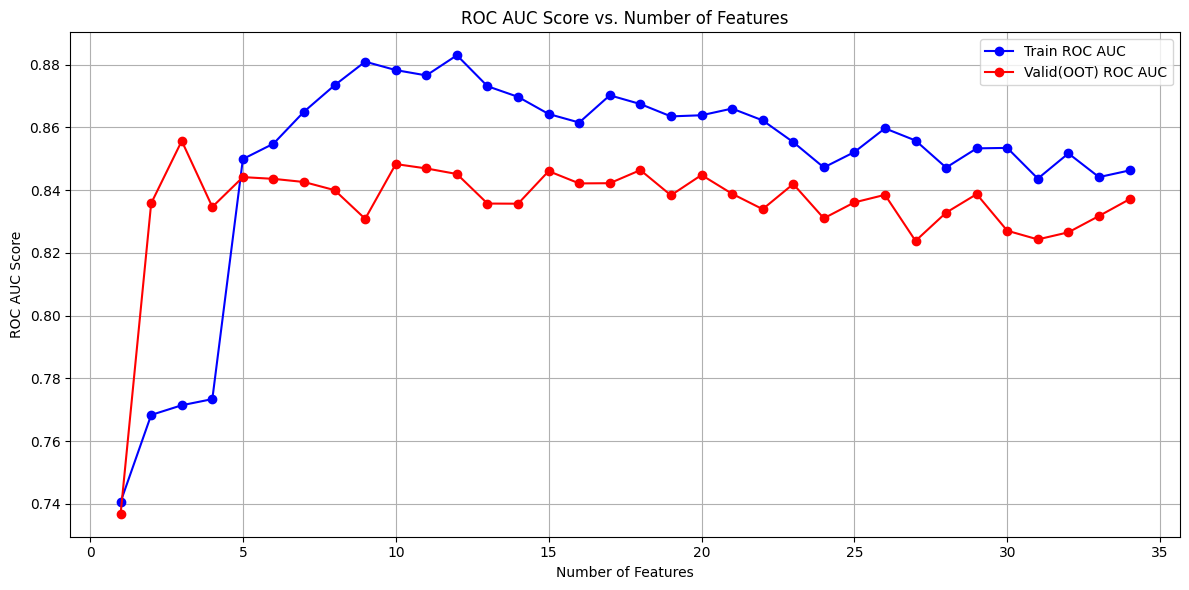

In [34]:
# График зависимости roc_auc от количества фичей
train_roc_aucs = [df[df['sample'] == 'Train']['roc_auc'].values[0] for df in history['metrics']]
valid_roc_aucs = [df[df['sample'] == 'Valid(OOT)']['roc_auc'].values[0] for df in history['metrics']]

num_features = history['num_feats']
plt.figure(figsize=(12, 6))
plt.plot(num_features, train_roc_aucs, marker='o', label='Train ROC AUC', color='blue')
plt.plot(num_features, valid_roc_aucs, marker='o', label='Valid(OOT) ROC AUC', color='red')
plt.title('ROC AUC Score vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('ROC AUC Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
final_features_pt1 = history['sel_feats'][-1] #Первая часть финальных фичей

In [45]:
df_new = df.copy()
df_new['report_date'] = df_new['report_date'].astype('datetime64[ns]')
df_new = df_new.sort_values(by='report_date')

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

def compare_columns(df):
    columns = df.columns.tolist()
    # print(columns)
    results = pd.DataFrame(index=columns, columns=columns)

    for col1 in columns:
        for col2 in columns:
            set1 = set(df[col1].dropna().unique())
            set2 = set(df[col2].dropna().unique())
            results.loc[col1, col2] = jaccard_similarity(set1, set2)

    return results

cat_columns = df_new.select_dtypes('object')
compare_df = compare_columns(cat_columns)

def get_unique_columns(similarity_matrix, threshold=0.26):

    columns_to_remove = set()
    for i in range(similarity_matrix.shape[0]):
        for j in range(i+1, similarity_matrix.shape[1]):
            if isinstance(similarity_matrix, np.ndarray):
                value = similarity_matrix[i, j]
            else:  # Если это DataFrame
                value = similarity_matrix.iloc[i, j]
            if value >= threshold:
                columns_to_remove.add(j)

    # Получить названия удаленных колонок (если это DataFrame)
    if isinstance(similarity_matrix, pd.DataFrame):
        removed_column_names = [similarity_matrix.columns[i] for i in columns_to_remove]

    # Удалить дублирующиеся колонки из матрицы
    if isinstance(similarity_matrix, np.ndarray):
        updated_matrix = np.delete(similarity_matrix, list(columns_to_remove), axis=1)
        updated_matrix = np.delete(updated_matrix, list(columns_to_remove), axis=0)
    else:  # Если это DataFrame
        updated_matrix = similarity_matrix.drop(similarity_matrix.columns[list(columns_to_remove)], axis=1)
        updated_matrix = updated_matrix.drop(similarity_matrix.index[list(columns_to_remove)], axis=0)

    return updated_matrix

mat = get_unique_columns(compare_df)

In [48]:
final_features_pt2 = mat.columns.tolist()

In [52]:
final_features = list(set(final_features_pt1 + final_features_pt2))